In [1]:
# BERT - Twitter-roBERTa-base
!pip install transformers>=4.0
!pip install sentencepiece
!pip install git+https://github.com/tweepy/tweepy.git --upgrade
!pip install spacy
!pip install circlify

import tensorflow as tf
assert tf.__version__ >= "2.0"

import matplotlib.pyplot as plt
import nltk
import spacy
import spacy.cli

import numpy as np
import pandas as pd
import tweepy
import json
import time
import calendar
import circlify
import re 

from wordcloud import WordCloud
from nltk.corpus import stopwords
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

# DL frequent words FR 
spacy.cli.download("fr_core_news_sm")
nltk.download('stopwords')
nlp = spacy.load("fr_core_news_sm")
stopWords = set(stopwords.words('french'))

# initialize model 
task='sentiment'
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [41]:
# API TWiiter 

def nlp_pipeline(text):
    # remove specific caract usefull for help IA
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = ' '.join(text.split())
    text = re.sub(r"(\s\-\s|-$)", "", text)
    text = re.sub(r"\?", "", text)
    text = re.sub(r"https://", "", text)

    return text

# Initialization Tweepy for use Twitter APi v2
client = tweepy.Client(bearer_token='insert your bearer_token')

# create dataFrame with columns 
df = pd.DataFrame(columns=['Sentiment', 'Score', 'Id_Tweet', 'Negative', 'Neutral', 'Positive', 'Text_Tweet', 'Date_Tweet', 'Nb_interaction', 'retweet_count', 'reply_count', 'like_count', 'quote_count'])

# ID User 
id_User = 000000000

# Lest tweet id of the user 
sauv_id = 00000000000000

# Retrive maximum tweets of users (max 3200)
tweets = tweepy.Paginator(client.get_users_tweets, id_User, until_id = sauv_id, max_results=100,
                        tweet_fields=['created_at', 'public_metrics', 'in_reply_to_user_id', 'referenced_tweets'], expansions=['author_id'], limit=100)

for x in tweets:
  for i in x.data:

    #  Remove Replies and Retweets 
    if i.in_reply_to_user_id == None and i.referenced_tweets == None:
      if i.id == sauv_id: 
        break
      
      # remove spécifics caract in text
      text = nlp_pipeline(i.text)

      # detect Text sentiment 
      encoded_input = tokenizer(text, return_tensors='pt')
      output = model(**encoded_input)
      scores = output[0][0].detach().numpy()

      # Format outup : [Negative - Neutral - Positive]
      scores = softmax(scores)

      # Collect the max score and the sentment
      ranking = np.argsort(scores)
      ranking = ranking[::-1]

      l = config.id2label[ranking[0]]
      s = scores[ranking[0]]
      st_score = np.round(float(s), 3)

      # Retrieve Metrics , interactions 
      nb_inter = 0
      retweet_count = i.public_metrics['retweet_count']
      reply_count = i.public_metrics['reply_count']
      like_count = i.public_metrics['like_count']
      quote_count = i.public_metrics['quote_count']
      nb_inter = retweet_count + reply_count + like_count + quote_count

      # insert in DataFrame
      df = df.append({'Sentiment': l,'Score': st_score, 'Id_Tweet': i.id, 'Negative': scores[0], 'Neutral': scores[1], 'Positive': scores[2],
                      'Text_Tweet': text, 'Date_Tweet': i.created_at, 'Nb_interaction': nb_inter, 'retweet_count':retweet_count, 'reply_count':reply_count, 'like_count':like_count, 'quote_count':quote_count}, ignore_index=True)

      sauv_id = i.id

# insert in CSV
df.to_csv('out.csv', index=False, header=True)


In [64]:
# Param for graph and format data

df_graph = pd.read_csv('out.csv')

# count nb of tweets by sentiments
res_sentiment = df_graph['Sentiment'].value_counts()

# sort by index (date)
res_sentiment = res_sentiment.sort_index()

# nb interactions
nb_inter_neg = df_graph[df_graph['Sentiment'] == 'Negative']['Nb_interaction'].sum()
nb_inter_neu = df_graph[df_graph['Sentiment'] == 'Neutral']['Nb_interaction'].sum()
nb_inter_pos = df_graph[df_graph['Sentiment'] == 'Positive']['Nb_interaction'].sum()

# nb Retweets
nb_rt_neg = df_graph[df_graph['Sentiment'] == 'Negative']['retweet_count'].sum()
nb_rt_neu = df_graph[df_graph['Sentiment'] == 'Neutral']['retweet_count'].sum()
nb_rt_pos = df_graph[df_graph['Sentiment'] == 'Positive']['retweet_count'].sum()

# nb replies
nb_reply_neg = df_graph[df_graph['Sentiment'] == 'Negative']['reply_count'].sum()
nb_reply_neu = df_graph[df_graph['Sentiment'] == 'Neutral']['reply_count'].sum()
nb_reply_pos = df_graph[df_graph['Sentiment'] == 'Positive']['reply_count'].sum()

# nb Like
nb_like_neg = df_graph[df_graph['Sentiment'] == 'Negative']['like_count'].sum()
nb_like_neu = df_graph[df_graph['Sentiment'] == 'Neutral']['like_count'].sum()
nb_like_pos = df_graph[df_graph['Sentiment'] == 'Positive']['like_count'].sum()

# nb Quote
nb_quote_neg = df_graph[df_graph['Sentiment'] == 'Negative']['quote_count'].sum()
nb_quote_neu = df_graph[df_graph['Sentiment'] == 'Neutral']['quote_count'].sum()
nb_quote_pos = df_graph[df_graph['Sentiment'] == 'Positive']['quote_count'].sum()

# nb Tweets by Sentiments 
nb_tweet = df_graph.count()
nb_tweet_neg = df_graph[df_graph['Sentiment'] == 'Negative'].count()
nb_tweet_neu = df_graph[df_graph['Sentiment'] == 'Neutral'].count()
nb_tweet_pos = df_graph[df_graph['Sentiment'] == 'Positive'].count()

backColor = '#001219'
backGraphColor = '#ADB5BD'

txt_sentiments = ["Negatifs", "Neutre", "Positifs"]
colors = ["#800E16", "#F7B801", "#003D1E"]
sub_title = f"{nb_tweet[0]} Tweets analysés du 2021-10-06 au 2022-11-12"
explode = (0.04,0,0)

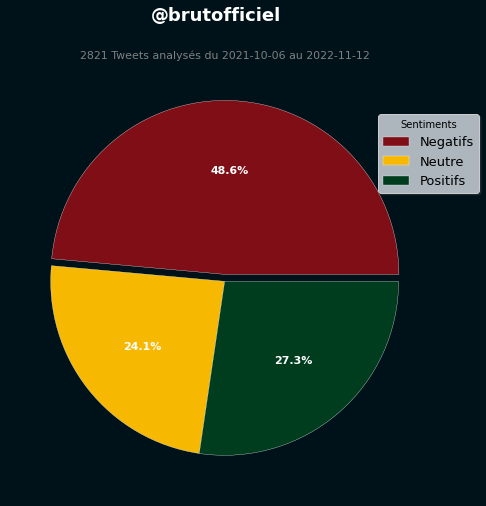

In [49]:
# graph PIE - Pourcent sentiments of tweets 

data_graph = [res_sentiment[0], res_sentiment[1], res_sentiment[2]]

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor(backColor)

plt.pie(data_graph,
        # labels = txt_sentiments,
        autopct = '%1.1f%%',
        textprops = dict(color ="w", fontsize='11',fontweight ='bold'),
        explode=explode,
        wedgeprops = {'linewidth': 0.3, 'edgecolor': "w"},
        colors=colors)

# Title
plt.suptitle('@brutofficiel',fontweight='bold', fontsize='18', color='w')
plt.title(sub_title, fontsize='11', color='grey')

# Legend
lg = ax.legend(txt_sentiments, title ="Sentiments", loc ="upper right", bbox_to_anchor =(1, -0.1, 0.1, 1), shadow=True,  fontsize='13')
lg.get_frame().set_facecolor('#adb5bd')

plt.show() 

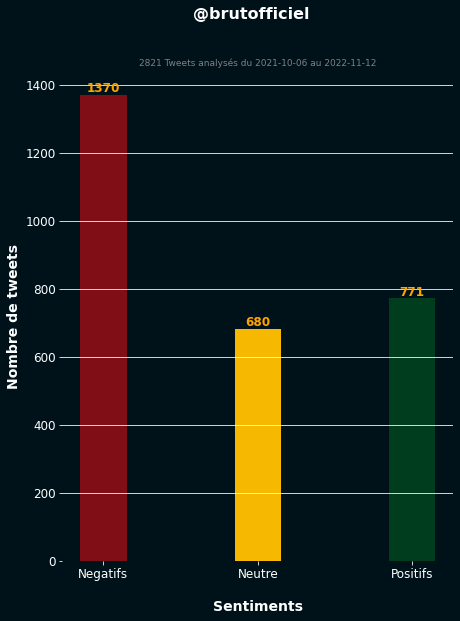

In [50]:
# graph BAR - sentiments of tweets - pourcent / numbers 
data_graph = [res_sentiment[0], res_sentiment[1], res_sentiment[2]]

# create graph
fig, ax = plt.subplots(figsize=(7, 9))
fig.patch.set_facecolor(backColor)
ax.set_facecolor(backColor)
plt.bar(txt_sentiments, data_graph, width = 0.3, color=colors)

# Titles
plt.suptitle('@brutofficiel',fontweight='bold', fontsize='16', color='w')
plt.title(sub_title, fontsize='9', color='grey')

# axes 
plt.xlabel('Sentiments', fontweight='bold', color = 'w', fontsize='14', horizontalalignment='center',  labelpad=1)
plt.ylabel('Nombre de tweets', fontweight='bold', color = 'w', fontsize='14', horizontalalignment='center')
ax.tick_params(colors='w', labelsize=12)
ax.xaxis.set_label_coords(0.5, -0.08)


# Grid
ax.grid(axis = 'y', color='w');
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add annotation to bars
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2,
                bar.get_height()),
                ha='center',
                va='center',
                size=12,
                xytext=(0,7),
                textcoords='offset points',
                color='orange',
                fontweight='bold')

plt.show() 

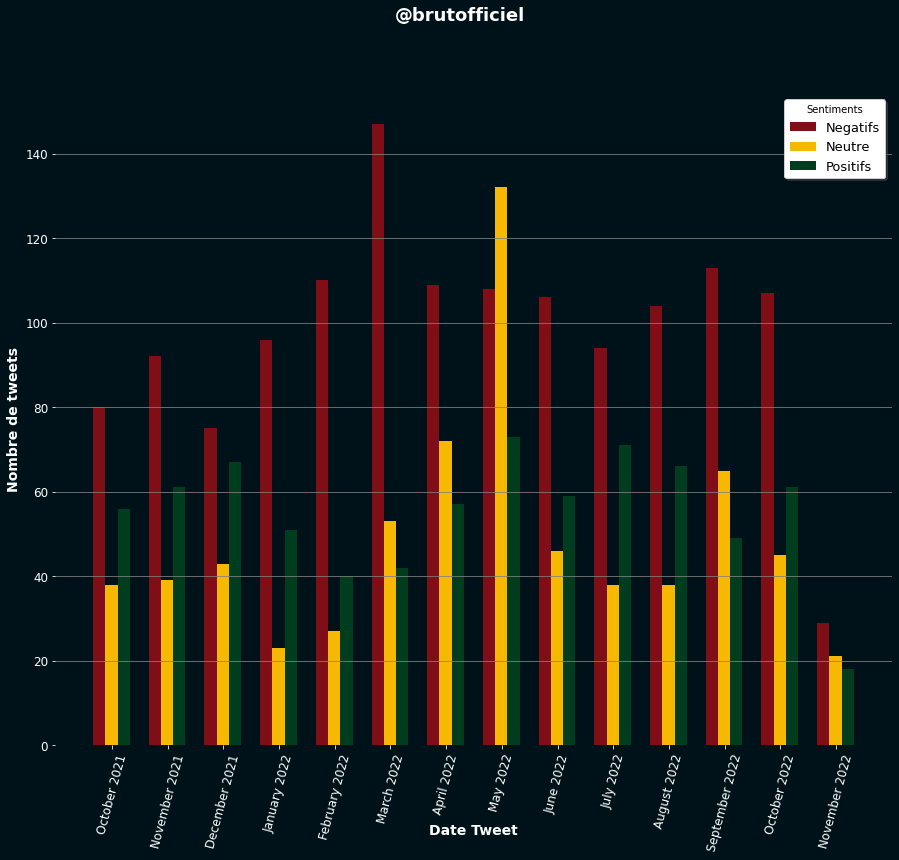

In [54]:
# Graph BAR - Number of Tweets by Sentiments by month 

# Convert column Date_Tweets str to DateTime
df_graph['Date_Tweet'] = pd.to_datetime(df_graph['Date_Tweet'], utc=True)


# group by Month and Year
data_graph_month = df_graph.sort_values(['Date_Tweet']).groupby([df_graph.Date_Tweet.dt.year, df_graph.Date_Tweet.dt.month])['Sentiment'].value_counts()

# Retrieve values in Series
values = data_graph_month.values

# data for graph
arr_neg = []
arr_pos = []
arr_neu = []
arr_date = []

x = 0 
for i in data_graph_month.index:
  # insert in array
  if i[2] == "Negative":
    arr_neg.append(values[x])
  elif i[2] == "Positive":
    arr_pos.append(values[x])
  else :
    arr_neu.append(values[x])
    arr_date.append(calendar.month_name[i[1]] +' '+ str(i[0]))
  x += 1

# remove duplicate
set(arr_date)

# Param for graph
N = len(arr_neg)
ind = np.arange(N) 
width = 0.22

# create graph 
fig, ax = plt.subplots(figsize=(15,12))
fig.patch.set_facecolor(backColor)
ax.set_facecolor(backColor)

# Bars
plt.bar(ind, arr_neg, width, color = colors[0])
plt.bar(ind+width, arr_neu, width, color = colors[1])
plt.bar(ind+width*2, arr_pos, width, color=colors[2])

# Titles
plt.suptitle('@brutofficiel',fontweight='bold', fontsize='18', color='w')

# axes 
plt.xticks(ind + width/2 + 0.12,arr_date)
plt.xlabel('Date Tweet', fontweight='bold', color = 'w', fontsize='14', horizontalalignment='center',  labelpad=1)
plt.ylabel('Nombre de tweets', fontweight='bold', color = 'w', fontsize='14', horizontalalignment='center')
ax.tick_params(colors='w', labelsize=12)
ax.xaxis.set_label_coords(0.5, -0.12)
plt.xticks(rotation=75)


# Grid
ax.grid(axis = 'y', color='grey');
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.legend(txt_sentiments, title ="Sentiments", loc ="upper right", shadow=True,  fontsize='13')
plt.show() 

In [45]:
# Retrieve frequent words in tweets 

def nlp_pipeline(text):
    # remove alla caract usefull for help textBlob
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = ' '.join(text.split())
    text = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", text)
    text = re.sub(r"(\s\-\s|-$)", "", text)
    text = re.sub(r"[?\%\(\)\/\|\"]", "", text)
    text = re.sub(r"\&\S*\s", "", text)
    text = re.sub(r"\&", "", text)
    text = re.sub(r"\+", "", text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"\$", "", text)
    text = re.sub(r"\£", "", text)
    text = re.sub(r"\%", "", text)
    text = re.sub(r"\:", "", text)
    text = re.sub(r"\@", "", text)
    text = re.sub(r"\-", "", text)
    return text
  
def token_text(sentence):
    # Tokenise sentence
    doc = nlp(sentence)
    return [X.text for X in doc]

df = pd.read_csv('out.csv')
dict_words = {}

for text in df['Text_Tweet']:

  # Remove frequents words FR with stopWords
  clean_words = []
  for token in token_text(text):
      if token not in stopWords:
          clean_words.append(token)

  # Retrieve words with more than 3 caract
  list_words = []
  for word in clean_words:
    if len(word) > 3:
      list_words.append(word)

  # sum duplicate words and add it in dict
  for x in list_words:
    if x not in dict_words.keys():
      dict_words[x] = 1
    else : 
      dict_words[x] += 1


df_words = pd.DataFrame(dict_words.items(), columns=['Mots', 'Nb occurences'])

# insert in CSV
df_words.to_csv('Frequent_Words.csv', index=False, header=True)


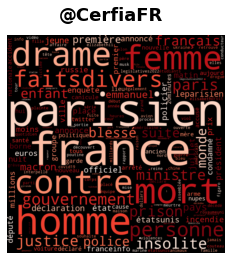

In [63]:
# graph Wordcloud
# First 180 frequents words 

df = pd.read_csv('Frequent_Words.csv')

list_w = df['Mots']
list_v = df['Nb occurences']

text_cloud = ""

# make a string with occurences
for i in range(len(list_w)):
  for x in range(1, list_v[i]):
    text_cloud += ' ' + list_w[i]

# Create the wordcloud object
wordcloud = WordCloud(width=900, height=900, margin=1, collocations=False, colormap="Reds").generate(text_cloud)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('@CerfiaFR',fontweight='bold', fontsize='18', color='black')
plt.show()

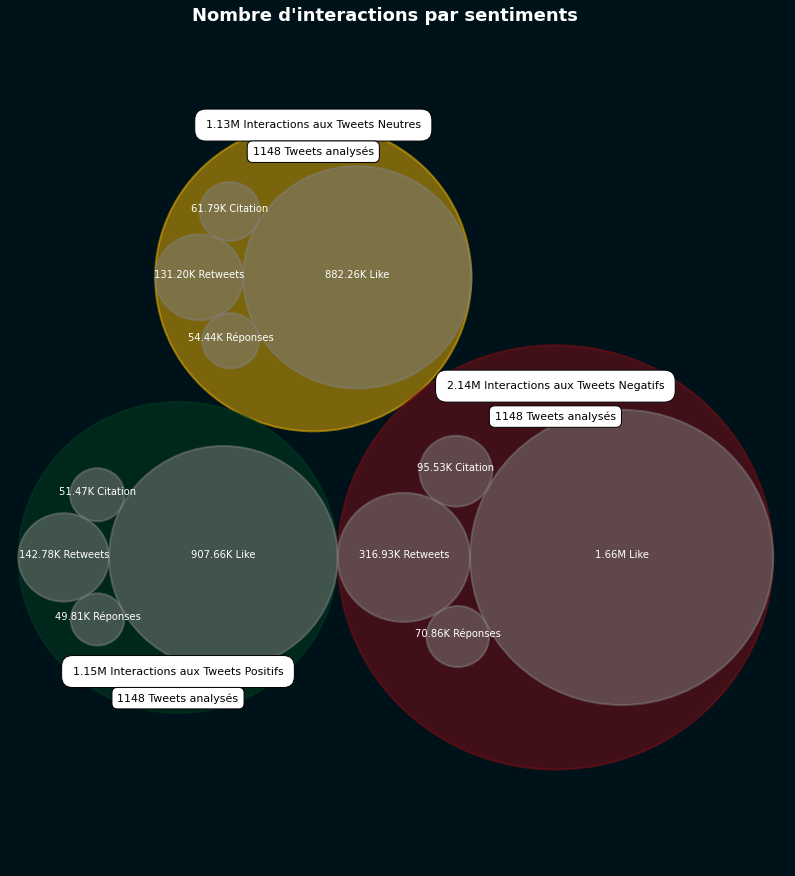

In [80]:
# Circle Packing Chart with Multi-Level Hierarchy
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

data = [{'id': 'All_interactions', 'datum': nb_inter_neg + nb_inter_neu + nb_inter_pos, 'children' : [
    {'id' : "Interactions aux Tweets Negatifs", 'datum': nb_inter_neg,
     'children' : [
         {'id' : "Retweets", 'datum' : nb_rt_neg},
         {'id' : "Like", 'datum' : nb_like_neg},
         {'id' : "Réponses", 'datum' : nb_reply_neg},
         {'id' : "Citation", 'datum' : nb_quote_neg}
         ]},
         {'id' : "Interactions aux Tweets Neutres", 'datum' : nb_inter_neu, 
          'children' : [
              {'id' : "Retweets", 'datum' : nb_rt_neu},
              {'id' : "Like", 'datum' : nb_like_neu},
              {'id' : "Réponses", 'datum' : nb_reply_neu},
              {'id' : "Citation", 'datum' : nb_quote_neu} 
              ]},
              {'id' : "Interactions aux Tweets Positifs", 'datum' : nb_inter_pos,  
               'children' : [
                   {'id' : "Retweets", 'datum' : nb_rt_pos},
                   {'id' : "Like", 'datum' : nb_like_pos},
                   {'id' : "Réponses", 'datum' : nb_reply_pos},
                   {'id' : "Citation", 'datum' : nb_quote_pos} 
                   ]}
                   ]}]

# Compute circle positions thanks to the circlify() function
circles = circlify.circlify(
    data, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(14,14))
fig.patch.set_facecolor(backColor)

# Title
plt.suptitle("Nombre d'interactions par sentiments",fontweight='bold', fontsize='18', color='w')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Print circle the highest level (continents):
for circle in circles:
    if circle.level != 2:
      continue

    x, y, r = circle
    if circle.ex["id"] == "Interactions aux Tweets Neutres":
      ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2, color=colors[1]))
    elif circle.ex["id"] == "Interactions aux Tweets Positifs":
      ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2, color=colors[2]))
    else:
      ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2, color=colors[0])) 

# Print circle and labels for the highest level:
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    value = circle.ex["datum"]
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="grey"))
    plt.annotate(f"{human_format(value)} {label}", (x,y ), ha='center', color="white")

# Print labels for the continents
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    if label == "Interactions aux Tweets Neutres":
      plt.annotate(f"{human_format(nb_inter_neu)} {label}", (x,y+0.40 ) ,va='center', ha='center',fontsize="11", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=1))
      plt.annotate(f"{nb_tweet_neu[0]} Tweets analysés", (x,y+0.33 ) ,va='center', ha='center', fontsize="11", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=0.5))
    elif label == "Interactions aux Tweets Positifs":
      plt.annotate(f"{human_format(nb_inter_pos)} {label}", (x,y-0.30) ,va='center', ha='center',fontsize="11", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=1))
      plt.annotate(f"{nb_tweet_pos[0]} Tweets analysés", (x,y-0.37 ) ,va='center', ha='center', fontsize="11", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=0.5))
    else:
      plt.annotate(f"{human_format(nb_inter_neg)} {label}", (x,y+0.45 ) ,va='center', ha='center', fontsize="11", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=1))
      plt.annotate(f"{nb_tweet_neg[0]} Tweets analysés", (x,y+0.37 ) ,va='center', ha='center', fontsize="11", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=0.5))

